# Glaucoma Segmentation


## Imports

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2 as cv
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from networks import *
from training import *
from utils import *
from ROI import *

# prepare_origa_dataset('../data/ORIGA', 0.0)
# prepare_drishti_dataset('../data/DRISHTI', 0.0)
# prepare_rimone_dataset('../data/RIMONE', 1.0)

In [2]:
MODEL_PATH = r'.\models\centernet.pth'
MODEL_SCALE = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CenterNet(n_classes=1, scale=MODEL_SCALE, base='resnet18', custom=True)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
print('Model loaded from', MODEL_PATH)

INPUT_SIZE = 512
transform = A.Compose([
    A.Resize(INPUT_SIZE, INPUT_SIZE, interpolation=cv.INTER_AREA),
    A.Normalize(mean=(0.9400, 0.6225, 0.3316), std=(0.1557, 0.1727, 0.1556)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))


Model loaded from .\models\centernet.pth


In [3]:
from tqdm import tqdm

images_dir = '../data/AllImages'
masks_dir = '../data/AllMasks'
rois_dir = '../data/AllROIs'

os.makedirs(rois_dir, exist_ok=True)

images = sorted(os.listdir(images_dir))
masks = sorted(os.listdir(masks_dir))

for img, mask in zip(tqdm(images), masks):
    img_path = os.path.join(images_dir, img)
    mask_path = os.path.join(masks_dir, mask)

    roi_image, roi_mask = detect_roi(
        model, img_path, mask_path, transform, INPUT_SIZE,
        device=DEVICE, small_margin=16, roi_size=512,
    )

    roi_mask = np.repeat(roi_mask[:, :, np.newaxis], 3, axis=2)
    roi_image[roi_mask == 1] = 255
    roi_image[roi_mask == 2] = 128

    # Save ROI image
    roi_image = cv.cvtColor(roi_image, cv.COLOR_RGB2BGR)
    cv.imwrite(os.path.join(rois_dir, img), roi_image)


100%|██████████| 910/910 [16:11<00:00,  1.07s/it]


## Setup

In [ ]:
IMAGE_DIR = '../data/ORIGA/Images_CenterNet_Cropped'
MASK_DIR = '../data/ORIGA/Masks_CenterNet_Cropped'
LOGS_DIR = '../logs/'
CHECKPOINT_DIR = '../checkpoints/'

NETWORK_NAME = 'refunet3+cbam'  # raunet++, refunet3+cbam, swinunet
OPTIMIZER = 'adam'
LOSS_FUNCTION = 'combo'
ARCHITECTURE = 'binary'  # multiclass, multilabel, binary, dual, cascade
BINARY_TARGET_CLASSES = [1, 2]
SCHEDULER = 'plateau'
SCALER = 'none'
DATASET = 'ORIGA'
BASE_CASCADE_MODEL = ''

IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
IN_CHANNELS, OUT_CHANNELS = 3, 1
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
EPOCHS = 5
LAYERS = [16, 32, 48, 64, 80]
CLASS_WEIGHTS = None
SET_SIZES = [0.8, 0.1, 0.1]
DROPOUT_2D = 0.2
EARLY_STOPPING_PATIENCE = 11
LOG_INTERVAL = 5
SAVE_INTERVAL = 10
NUM_WORKERS = 0

USE_WANDB = False
POLAR_TRANSFORM = True
MULTI_SCALE_INPUT = False
DEEP_SUPERVISION = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PIN_MEMORY = True if DEVICE == 'cuda' else False

os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f'''CONFIGURATION:
    PyTorch version: {torch.__version__}
    NumPy version: {np.__version__}
    OpenCV version: {cv.__version__}

    Network: {NETWORK_NAME}
    Architecture: {ARCHITECTURE}
    Optimizer: {OPTIMIZER}
    Loss function: {LOSS_FUNCTION}
    Scheduler: {SCHEDULER}
    Scaler: {SCALER}
    Using device: {DEVICE}

    Dataset: {DATASET}
    Dataset proportions: {SET_SIZES}
    Image directory: {IMAGE_DIR}
    Mask directory: {MASK_DIR}
    Input image height & width: {IMAGE_HEIGHT}x{IMAGE_WIDTH}
    Number of input channels: {IN_CHANNELS}
    Number of output channels: {OUT_CHANNELS}

    Layers: {LAYERS}
    Batch size: {BATCH_SIZE}
    Learning rate: {LEARNING_RATE}
    Epochs: {EPOCHS}
    Class weights: {CLASS_WEIGHTS}
    Dropout: {DROPOUT_2D}
    Early stopping patience: {EARLY_STOPPING_PATIENCE}

    Save interval: {SAVE_INTERVAL}
    Log interval: {LOG_INTERVAL}
    Number of workers: {NUM_WORKERS}
    Pin memory: {PIN_MEMORY}

    Weight & Biases: {USE_WANDB}
    Polar transform: {POLAR_TRANSFORM}
    Multi-scale input: {MULTI_SCALE_INPUT}
    Deep supervision: {DEEP_SUPERVISION}''')

## Dataset

In [ ]:
polar_transform_partial = partial(polar_transform, radius_ratio=1.0)

train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, interpolation=cv.INTER_AREA),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    A.CLAHE(p=1.0, clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True),
    A.RandomBrightnessContrast(p=0.5),
    # A.GridDistortion(p=0.5, border_mode=cv.BORDER_CONSTANT),
    # A.MedianBlur(p=0.5),
    # A.RandomToneCurve(p=0.5),
    # A.MultiplicativeNoise(p=0.5),
    # A.Lambda(image=sharpen, p=1.0),
    A.Lambda(image=polar_transform_partial, mask=polar_transform_partial) if POLAR_TRANSFORM else A.Lambda(),
    # A.Lambda(image=keep_gray_channel),
    # A.Lambda(image=keep_red_channel),
    # A.Lambda(image=keep_green_channel),
    # A.Lambda(image=keep_blue_channel),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, interpolation=cv.INTER_AREA),
    A.CLAHE(p=1.0, clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True),
    A.Lambda(image=polar_transform_partial, mask=polar_transform_partial) if POLAR_TRANSFORM else A.Lambda(),
    # A.Lambda(image=keep_gray_channel),
    # A.Lambda(image=keep_red_channel),
    # A.Lambda(image=keep_green_channel),
    # A.Lambda(image=keep_blue_channel),
    ToTensorV2(),
])

train_loader, val_loader, test_loader = load_dataset(
    IMAGE_DIR, MASK_DIR, None, None, *SET_SIZES,
    train_transform, val_transform, val_transform, BATCH_SIZE, PIN_MEMORY, NUM_WORKERS,
)

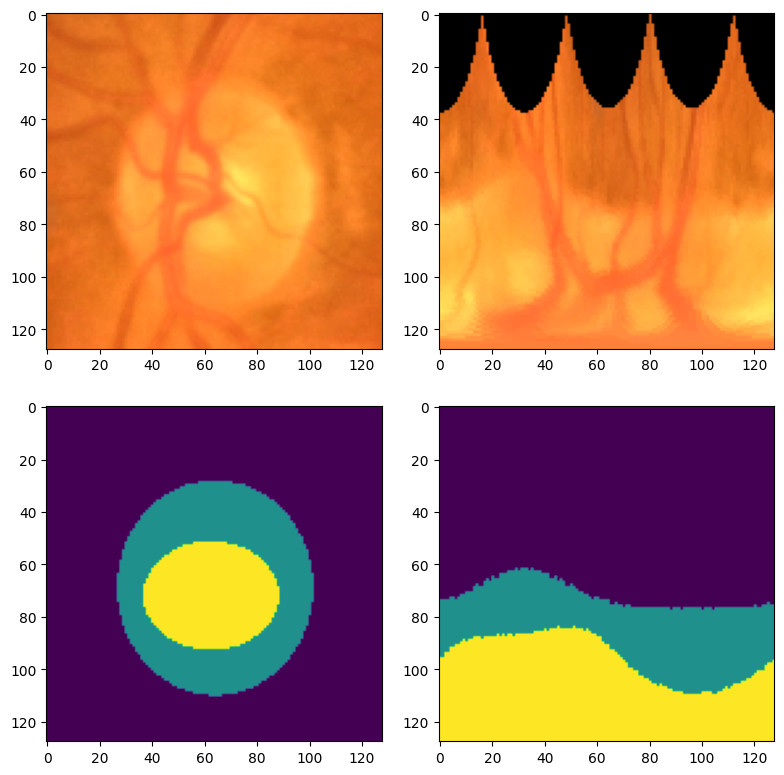

In [8]:
images, masks = next(iter(val_loader))
image = images[0].permute(1, 2, 0).numpy()
mask = masks[0].numpy()

polar_image = polar_transform(image)
polar_mask = polar_transform(mask)

_, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(image)
ax[0, 1].imshow(polar_image)
ax[1, 0].imshow(mask)
ax[1, 1].imshow(polar_mask)
plt.tight_layout()
plt.show()

## Model

In [ ]:
model = None
binary_model = None
hist = None

if NETWORK_NAME == 'raunet++':
    model = RAUnetPlusPlus(
        in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, features=LAYERS,
        multi_scale_input=MULTI_SCALE_INPUT, deep_supervision=DEEP_SUPERVISION, dropout=DROPOUT_2D,
    )

if NETWORK_NAME == 'refunet3+cbam':
    model = RefUnet3PlusCBAM(
        in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, features=LAYERS,
        multi_scale_input=MULTI_SCALE_INPUT, dropout=DROPOUT_2D,
    )

if NETWORK_NAME == 'swinunet':
    model = SwinUnet(
        in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, img_size=224, patch_size=4,
    )

if NETWORK_NAME == 'dual-raunet++':
    model = DualRAUnetPlusPlus(
        in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, features=LAYERS,
        multi_scale_input=MULTI_SCALE_INPUT, deep_supervision=DEEP_SUPERVISION, dropout=DROPOUT_2D,
    )

if NETWORK_NAME == 'dual-refunet3+cbam':
    model = DualRefUnet3PlusCBAM(
        in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, features=LAYERS,
        multi_scale_input=MULTI_SCALE_INPUT, dropout=DROPOUT_2D,
    )

if NETWORK_NAME == 'dual-swinunet':
    model = DualSwinUnet(
        in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, img_size=224, patch_size=4,
    )

assert model is not None, 'Invalid network name'

model = model.to(DEVICE)
init_model_weights(model)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = ComboLoss(num_classes=OUT_CHANNELS if ARCHITECTURE == 'multiclass' else 1, class_weights=CLASS_WEIGHTS)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)
scaler = None

if BASE_CASCADE_MODEL:
    checkpoint = load_checkpoint(BASE_CASCADE_MODEL)
    binary_model = checkpoint['model']

In [ ]:
# WEIGHT_DECAY = 1e-4
# 
# model = SwinUnet(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, img_size=224, patch_size=4).to(DEVICE)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose=True)

In [ ]:
# hist = train_multiclass(
#     model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler,
#     save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
#     log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
#     save_best_model=True, plot_examples='all', show_plots=True,
# )
# plot_history(hist)

## Training

In [ ]:
if ARCHITECTURE == 'multiclass':
    hist = train_multiclass(
        model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False,
        inverse_transform=undo_polar_transform if POLAR_TRANSFORM else None,
    )

if ARCHITECTURE == 'multilabel':
    hist = train_multilabel(
        model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False,
        inverse_transform=undo_polar_transform if POLAR_TRANSFORM else None,
    )

if ARCHITECTURE == 'binary':
    hist = train_binary(
        model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False, target_ids=BINARY_TARGET_CLASSES,
        inverse_transform=undo_polar_transform if POLAR_TRANSFORM else None,
    )

if ARCHITECTURE == 'cascade':
    assert binary_model is not None, 'Base model not specified'
    hist = train_cascade(
        binary_model, model, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False,
        inverse_transform=undo_polar_transform if POLAR_TRANSFORM else None,
    )

if ARCHITECTURE == 'dual':
    hist = train_dual(
        model, criterion, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, scaler,
        save_interval=SAVE_INTERVAL, early_stopping_patience=EARLY_STOPPING_PATIENCE,
        log_to_wandb=USE_WANDB, log_dir=LOGS_DIR, log_interval=LOG_INTERVAL, checkpoint_dir=CHECKPOINT_DIR,
        save_best_model=True, plot_examples='none', show_plots=False,
        inverse_transform=undo_polar_transform if POLAR_TRANSFORM else None,
    )


In [ ]:
plot_history(hist)

## Testing

In [ ]:
if ARCHITECTURE == 'multiclass':
    results = evaluate('multiclass', model, test_loader, criterion, DEVICE)

if ARCHITECTURE == 'multilabel':
    results = evaluate('multilabel', model, test_loader, criterion, DEVICE)

if ARCHITECTURE == 'binary':
    results = evaluate('binary', model, test_loader, criterion, DEVICE, class_ids=BINARY_TARGET_CLASSES)

if ARCHITECTURE == 'dual':
    results = evaluate('dual', model, test_loader, criterion, DEVICE)

if ARCHITECTURE == 'cascade':
    results = evaluate('cascade', model, test_loader, criterion, DEVICE, model0=binary_model)

In [ ]:
if ARCHITECTURE == 'multiclass':
    plot_results_from_loader(
        'multiclass', test_loader, model, DEVICE, n_samples=4,
        save_path=f'{LOGS_DIR}/evaluation.png',
    )

if ARCHITECTURE == 'multilabel':
    plot_results_from_loader(
        'multilabel', test_loader, model, DEVICE, n_samples=4,
        save_path=f'{LOGS_DIR}/evaluation.png',
    )

if ARCHITECTURE == 'binary':
    plot_results_from_loader(
        'binary', test_loader, model, DEVICE, n_samples=4,
        save_path=f'{LOGS_DIR}/evaluation.png', class_ids=BINARY_TARGET_CLASSES,
    )

if ARCHITECTURE == 'dual':
    plot_results_from_loader(
        'dual', test_loader, model, DEVICE,
        n_samples=4, save_path=f'{LOGS_DIR}/evaluation.png',
    )

if ARCHITECTURE == 'cascade':
    plot_results_from_loader(
        'cascade', test_loader, model, DEVICE, n_samples=4,
        save_path=f'{LOGS_DIR}/evaluation.png', model0=binary_model,
    )